# 学習済みモデル

## ライブラリのインポート

`tensorflow`を使って物体検出などのモデルを使ってみましょう

In [1]:
import tensorflow as tf
# バージョンを確認します
print(tf.__version__)

2.6.4


## TensorFlow, Kerasで利用できる学習済みモデル一覧

### 学習済みモデルとは

レイヤとその重みが定義され、[ImageNet](https://www.image-net.org/index.php)などの画像データセットをもって既に学習されたモデル。

転移学習やファインチューニングをして応用することができるが、そのまま使うこともできる

### kerasに組み込まれている学習済みモデルの一覧

https://keras.io/api/applications/

## 学習済みモデルの読み込み

ここでは[vgg16](https://jp.mathworks.com/help/deeplearning/ref/vgg16.html)というモデルをロードしてみましょう。（学習データは大きいので何度も実行しないように）

In [2]:
model = tf.keras.applications.vgg16.VGG16(weights=None)

2023-02-07 09:34:15.988138: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## 構造をみる
`summary()`関数を使ってどのような構造になっているのか見てみましょう

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 入力の形(input_shape)、出力(output_shape)、学習パラメーター(params)の数はいくつでしょうか

In [4]:
input_shape = []
output_shape = []
prams = 0

## 他にもいくつか学習済みモデルをインポートして、そのレイヤを見てみましょう。

# 画像処理ライブラリPillow(PIL)の使い方

Pillow(PIL)はPythonの画像処理ライブラリです。

## 画像の読み込み

`open()`メソッドを使って画像を読み込むことができます。

In [5]:
#help(Image.open)

In [6]:
from PIL import Image

im = Image.open('/kaggle/input/cat-and-dog/training_set/training_set/dogs/dog.1.jpg')

## 画像の表示

jupyter-notebookではコードセルの最後の行に`PIL`型の変数を指定すれば描画してくれます。

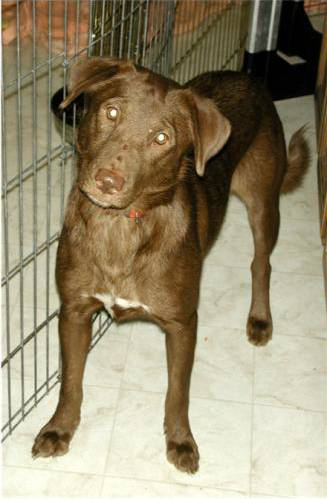

In [7]:
im

## 画像のサイズを確認

In [8]:
(width, height) = im.size
print(f"横幅: {width}px")
print(f"縦幅: {height}px")

横幅: 327px
縦幅: 499px


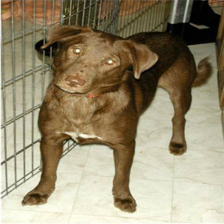

In [9]:
img_resized = im.resize((224, 224))
img_resized

## 型を変換する

モデルの入力は`numpy array`なので、型を変換する必要があります

In [10]:
img_np = tf.keras.preprocessing.image.img_to_array(img_resized)
print(type(img_np))
img_np.shape

<class 'numpy.ndarray'>


(224, 224, 3)

## 最後の数値は何？

`img_np.shape`の結果は`(224, 224, 3)`のように表示されましたが、最後の3は何を意味するのでしょうか？


In [11]:
# 画像の左上のピクセル
img_np[0][0]

array([220., 207., 193.], dtype=float32)

## 入力の次元拡張

さきほどのモデルの入力を見てみると、入力は`[(None, 224, 224, 3)]`となっています。

モデルの入力はバッチ数も含むので次元を拡張する必要があります。

In [12]:
expanded_img = img_np[tf.newaxis, ...]
# 確認してみましょう
expanded_img.shape

(1, 224, 224, 3)

## 前処理

前処理をすると予測精度が向上する。(このセルを何度も実行しないように）

In [13]:
img_preprocessed = tf.keras.applications.vgg16.preprocess_input(expanded_img)
print(img_preprocessed.min(), '-', img_preprocessed.max())

-123.68 - 146.061


## preprocess_input

前処理の関数`preprocess_input`の[ドキュメント](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)を読んでみましょう

The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

## 何が変わったのか見てみる

In [14]:
expanded_img[0][0][0]

array([96.32 , 90.221, 89.061], dtype=float32)

In [15]:
img_preprocessed[0][0][0]

array([89.061, 90.221, 96.32 ], dtype=float32)

左から10番目、上から20番目のピクセルを取り出す方法は？

In [16]:
pixel_left10_up20 = 0

## 画像を入力して予想してみましょう

In [17]:
prediction = model.predict(img_preprocessed)

2023-02-07 09:34:18.931102: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## 正しい出力の形になっているか確認しましょう

In [18]:
prediction.shape

(1, 1000)

In [19]:
prediction[0][:5]

array([0.00073676, 0.00086475, 0.00125813, 0.00098192, 0.00083063],
      dtype=float32)

In [20]:
import pprint
result = tf.keras.applications.vgg16.decode_predictions(prediction, top=5)
pprint.pprint(result)

49152/35363 [=========================================] - 0s 0us/step
[[('n03781244', 'monastery', 0.002096985),
  ('n01796340', 'ptarmigan', 0.0020186794),
  ('n07892512', 'red_wine', 0.0019383082),
  ('n03584254', 'iPod', 0.0019052955),
  ('n02749479', 'assault_rifle', 0.0018237111)]]


## 分類ラベル一覧

Imagenetの1000クラス分の順番とラベル、クラス名の情報は[JSONファイル](https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json)にまとめられています

## どのようなラベルがあるのか、5つピックアップしてみましょう。

# 練習1

`/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.1.jpg`を読み込み、画像分類してみましょう

# 練習2
好きなモデル/データセットを選んで画像分類してみましょう

- モデルの定義
- 画像の読み込み
- 予想結果の表示

# [Tensorflow Hub](https://www.tensorflow.org/hub)

Tensorflow Hubは学習済みモデルのレポジトリです。kerasの学習済みモデルより幅広く、応用しやすくなっています。

まずは[Faster R-CNN](https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1)をつかってみましょう。

このモデルは**物体検出**と**分類**を順番に実行してくれます。

In [21]:
import tensorflow as tf
import tensorflow_hub as hub

# 画像データの読み込み
image = tf.io.read_file("/kaggle/input/cat-and-dog/training_set/training_set/dogs/dog.1.jpg")
image = tf.io.decode_jpeg(image)
image = tf.expand_dims(image, axis=0)

# モデルをロード
tf_model = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1")

## 推論を実行

Tensorflow Hubモデルは、kerasのものと違って`.predict`は必要ありません

In [22]:
outputs = tf_model(image)

まずは型を確認しましょう

In [23]:
type(outputs)

dict

どのようなキーがあるのか確認しましょう

In [24]:
for key in outputs.keys():
    print(key)

detection_anchor_indices
detection_classes
detection_multiclass_scores
detection_scores
raw_detection_boxes
detection_boxes
num_detections
raw_detection_scores


In [25]:
boxes = outputs["detection_boxes"][0]

In [26]:
import numpy as np
height, width = image.shape[1:3]
box = boxes[0] * np.array([height, width, height, width])
y_min, x_min, y_max, x_max = box.numpy().astype(int)

## OpenCV

Pillowの他にもOpenCVという画像処理のライブラリがあります

In [27]:
import cv2
output_image = cv2.imread("/kaggle/input/cat-and-dog/training_set/training_set/dogs/dog.1.jpg")

## 枠線を描画する

`cv2.rectangle`という長方形を描画するメソッドを使います

In [28]:
result = cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), color=(0, 0, 255))

In [29]:
cv2.imwrite("output.jpg", output_image)

True

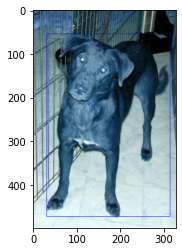

In [30]:
import matplotlib.pyplot as plt
plt.imshow(output_image)

## 練習1
好きな画像データセットを追加して、モデルを使って検出した物体に枠線をかいてみましょう

## 練習2

PILにも線を描画するメソッドがあります。その使い方を調べ、同様に検出した物体に枠線をかいてみましょう。

- キーワードでgoogle検索する 例. **PIL 線 描画**
- できるだけ一次情報、APIドキュメントを読む
- 実際にコーディングして確かめる
- `help`関数を使ってさらに詳しく調べる

# Fashion MNISTでの分類モデルの作成

[Fashion MNISTデータセット](https://www.kaggle.com/datasets/zalando-research/fashionmnist)を使って画像分類モデルを作成してみましょう。

## 参考

もっとも高い評価を受けているコードサンプル

https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide/notebook